**Medical Malpractice**





**Setup**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pandasql
import pandasql as ps

  Created wheel for pandasql: filename=pandasql-0.7.3-cp37-none-any.whl size=26784 sha256=abdb6308e1b09cd39409240f7ab3d6584d530fa4d01760f05399ba9f809aba62
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


Spark setup

In [ ]:
%%capture
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
%%capture
!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark

! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

In [ ]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev

In [ ]:
%%capture
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
import os

In [ ]:
%load_ext sparkmagic.magics

In [ ]:
%%capture
import os
os.environ['SPARK_HOME'] = "/content/spark-3.1.1-bin-hadoop3.2"
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
import pyspark
from pyspark.sql import SQLContext

In [ ]:
try:
    if(spark == None):
        spark = SparkSession.builder.appName('Initial').getOrCreate()
        sqlContext=SQLContext(spark)
except NameError:
    spark = SparkSession.builder.appName('Initial').getOrCreate()
    sqlContext=SQLContext(spark)

EMR Cluster Setup

In [ ]:
%spark delete -s my_session

In [ ]:
%spark add -s my_session -l python -u http://ec2-3-226-235-190.compute-1.amazonaws.com:8998

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1623865905980_0003,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


**I. Data Preprocessing and Feature Engineering**

Data preprocessing task list:
- Adjust payment feature for inflation
- Calculate years of experience
- Add "catastrophic" column (1 if payment exceeds threshold, 0 if it does not)

Step 1 - Data Loading

In this phase we load data to EMR Cluster 

In [ ]:
%%spark
spark_reader = spark.read
sdf = spark_reader.csv('s3://dspracticum/NPDB2010.CSV',inferSchema = True, header = True)
sdf.createOrReplaceTempView('sdf')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark
sdf.show(10)
sdf.dtypes

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+----+--------+--------+--------+-------+--------+--------+-------+--------+--------+--------+-------+--------+-----+--------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+----+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+
|SEQNO|RECTYPE|REPTYPE|ORIGYEAR|WORKSTAT|WORKCTRY|HOMESTAT|HOMECTRY|LICNSTAT|LICNFELD|PRACTAGE|GRAD|ALGNNATR|ALEGATN1|ALEGATN2|OUTCOME|MALYEAR1|MALYEAR2|PAYMENT|TOTALPMT|PAYNUMBR|NUMBPRSN|PAYTYPE|PYRRLTNS|PTAGE|PTGENDER|PTTYPE|AAYEAR|AACLASS1|AACLASS2|AACLASS3|AACLASS4|AACLASS5|BASISCD1|BASISCD2|BASISCD3|BASISCD4|BASISCD5|AALENTYP|AALENGTH|AAEFYEAR|AASIGYR|TYPE|PRACTNUM|ACCRRPTS|NPMALRPT|NPLICRPT|NPCLPRPT|NPPSMRPT|NPDEARPT|NPEXCRPT|NPGARPT|NPCTMRPT|FUNDPYMT|
+-----+-------+-------+--------+--------+--------+--------+--------+------

As it stands columns PAYMENT and TOTALPMT are string types. We now convert them to float.

In [ ]:
%%spark
from pyspark.sql.types import *

def to_float(x):
  """
  The PAYMENT and TOTALPMT columns of HRSA's data are inferred as string types by spark.
  This function removes the '$' character at each entry of the columns and casts the remaining characters
  into float.
  """
  if isinstance(x, str) and x[0] == '$':
    x = float(x[1:])
  return x

spark.udf.register("toFloat", to_float, FloatType())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<function to_float at 0x7f9b2be22e60>

In [ ]:
%%spark

query = '''
SELECT *, toFloat(TOTALPMT) as TOTALPMT_FLOAT
FROM sdf
'''
sdf_1 = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%spark
sdf_1.show(10)
sdf_1.dtypes
sdf_1.createOrReplaceTempView('sdf_1')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+----+--------+--------+--------+-------+--------+--------+-------+--------+--------+--------+-------+--------+-----+--------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+----+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+--------------+
|SEQNO|RECTYPE|REPTYPE|ORIGYEAR|WORKSTAT|WORKCTRY|HOMESTAT|HOMECTRY|LICNSTAT|LICNFELD|PRACTAGE|GRAD|ALGNNATR|ALEGATN1|ALEGATN2|OUTCOME|MALYEAR1|MALYEAR2|PAYMENT|TOTALPMT|PAYNUMBR|NUMBPRSN|PAYTYPE|PYRRLTNS|PTAGE|PTGENDER|PTTYPE|AAYEAR|AACLASS1|AACLASS2|AACLASS3|AACLASS4|AACLASS5|BASISCD1|BASISCD2|BASISCD3|BASISCD4|BASISCD5|AALENTYP|AALENGTH|AAEFYEAR|AASIGYR|TYPE|PRACTNUM|ACCRRPTS|NPMALRPT|NPLICRPT|NPCLPRPT|NPPSMRPT|NPDEARPT|NPEXCRPT|NPGARPT|NPCTMRPT|FUNDPYMT|TOTALPMT_FLOAT|
+-----+-------+-------+--------+--------+---

In [ ]:
%%spark
sdf_1.dtypes

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[('SEQNO', 'int'), ('RECTYPE', 'string'), ('REPTYPE', 'int'), ('ORIGYEAR', 'int'), ('WORKSTAT', 'string'), ('WORKCTRY', 'string'), ('HOMESTAT', 'string'), ('HOMECTRY', 'string'), ('LICNSTAT', 'string'), ('LICNFELD', 'int'), ('PRACTAGE', 'int'), ('GRAD', 'int'), ('ALGNNATR', 'int'), ('ALEGATN1', 'int'), ('ALEGATN2', 'int'), ('OUTCOME', 'int'), ('MALYEAR1', 'int'), ('MALYEAR2', 'int'), ('PAYMENT', 'string'), ('TOTALPMT', 'string'), ('PAYNUMBR', 'string'), ('NUMBPRSN', 'int'), ('PAYTYPE', 'string'), ('PYRRLTNS', 'string'), ('PTAGE', 'int'), ('PTGENDER', 'string'), ('PTTYPE', 'string'), ('AAYEAR', 'int'), ('AACLASS1', 'int'), ('AACLASS2', 'int'), ('AACLASS3', 'int'), ('AACLASS4', 'int'), ('AACLASS5', 'int'), ('BASISCD1', 'string'), ('BASISCD2', 'string'), ('BASISCD3', 'string'), ('BASISCD4', 'string'), ('BASISCD5', 'string'), ('AALENTYP', 'string'), ('AALENGTH', 'double'), ('AAEFYEAR', 'int'), ('AASIGYR', 'int'), ('TYPE', 'int'), ('PRACTNUM', 'int'), ('ACCRRPTS', 'int'), ('NPMALRPT', 'int'

In [ ]:
#check to see if all rows from TOTALPMT are converted to float in TOTALPMT_FLOAT

%%spark

query = '''
SELECT COUNT(TOTALPMT)
FROM sdf_1
WHERE TOTALPMT IS NOT NULL
'''

check_1 = spark.sql(query)
check_1.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+
|count(TOTALPMT)|
+---------------+
|         223926|
+---------------+

In [ ]:
%%spark
query = '''
SELECT COUNT(TOTALPMT_FLOAT), MAX(TOTALPMT_FLOAT), MIN(TOTALPMT_FLOAT), AVG(TOTALPMT_FLOAT)
FROM sdf_1
WHERE TOTALPMT_FLOAT IS NOT NULL
'''

check_2 = spark.sql(query)
check_2.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------+-------------------+-------------------+-------------------+
|count(TOTALPMT_FLOAT)|max(TOTALPMT_FLOAT)|min(TOTALPMT_FLOAT)|avg(TOTALPMT_FLOAT)|
+---------------------+-------------------+-------------------+-------------------+
|               223926|             1.05E8|               50.0|  312751.4205585774|
+---------------------+-------------------+-------------------+-------------------+

Both TOTALPMT and TOTALPMT_FLOAT has 223,926 entries. We can conclude that all entries are changed from string to float successfully.

I.a. Adjusting Payment Data for Inflation

First we bring in data from Bureau Labor of Statistics and merge inflation factor into the table.

In [ ]:
%%spark
inf_sdf = spark_reader.csv('s3://dspracticum/CPI_inf_factor.csv',inferSchema = True, header = True)
inf_sdf.createOrReplaceTempView('inf_sdf')
inf_sdf.show(10)
inf_sdf.dtypes

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-----+-----------+
|Year|Month|INF_APR2021|
+----+-----+-----------+
|1990| June|       2.06|
|1991| June|       1.96|
|1992| June|        1.9|
|1993| June|       1.85|
|1994| June|       1.84|
|1995| June|       1.75|
|1996| June|        1.7|
|1997| June|       1.67|
|1998| June|       1.64|
|1999| June|       1.61|
+----+-----+-----------+
only showing top 10 rows

[('Year', 'int'), ('Month', 'string'), ('INF_APR2021', 'double')]

In [ ]:
#merge the inflation data to the main sdf
%%spark

query = '''
SELECT *
FROM sdf_1 JOIN inf_sdf ON sdf_1.ORIGYEAR = inf_sdf.year
'''

sdf_2 = spark.sql(query)
sdf_2.show(10)
sdf_2.createOrReplaceTempView('sdf_2')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+----+--------+--------+--------+-------+--------+--------+-------+--------+--------+--------+-------+--------+-----+--------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+----+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+--------------+----+-----+-----------+
|SEQNO|RECTYPE|REPTYPE|ORIGYEAR|WORKSTAT|WORKCTRY|HOMESTAT|HOMECTRY|LICNSTAT|LICNFELD|PRACTAGE|GRAD|ALGNNATR|ALEGATN1|ALEGATN2|OUTCOME|MALYEAR1|MALYEAR2|PAYMENT|TOTALPMT|PAYNUMBR|NUMBPRSN|PAYTYPE|PYRRLTNS|PTAGE|PTGENDER|PTTYPE|AAYEAR|AACLASS1|AACLASS2|AACLASS3|AACLASS4|AACLASS5|BASISCD1|BASISCD2|BASISCD3|BASISCD4|BASISCD5|AALENTYP|AALENGTH|AAEFYEAR|AASIGYR|TYPE|PRACTNUM|ACCRRPTS|NPMALRPT|NPLICRPT|NPCLPRPT|NPPSMRPT|NPDEARPT|NPEXCRPT|NPGARPT|NPCTMRPT|FUNDPYMT|TOTALPMT_FLOAT|Year|Month|INF_APR2021

In [ ]:
# multiply TOTALPMT_FLOAT with INF_APR2021 to adjust the payment data for inflation
%%spark

query = '''
SELECT *, (TOTALPMT_FLOAT * INF_APR2021) AS TOTALPMT_ADJ
FROM sdf_2
'''

sdf_3 = spark.sql(query)
sdf_3.show(10)
sdf_3.createOrReplaceTempView('sdf_3')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+----+--------+--------+--------+-------+--------+--------+-------+--------+--------+--------+-------+--------+-----+--------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+----+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+--------------+----+-----+-----------+------------+
|SEQNO|RECTYPE|REPTYPE|ORIGYEAR|WORKSTAT|WORKCTRY|HOMESTAT|HOMECTRY|LICNSTAT|LICNFELD|PRACTAGE|GRAD|ALGNNATR|ALEGATN1|ALEGATN2|OUTCOME|MALYEAR1|MALYEAR2|PAYMENT|TOTALPMT|PAYNUMBR|NUMBPRSN|PAYTYPE|PYRRLTNS|PTAGE|PTGENDER|PTTYPE|AAYEAR|AACLASS1|AACLASS2|AACLASS3|AACLASS4|AACLASS5|BASISCD1|BASISCD2|BASISCD3|BASISCD4|BASISCD5|AALENTYP|AALENGTH|AAEFYEAR|AASIGYR|TYPE|PRACTNUM|ACCRRPTS|NPMALRPT|NPLICRPT|NPCLPRPT|NPPSMRPT|NPDEARPT|NPEXCRPT|NPGARPT|NPCTMRPT|FUNDPYMT|TOTALPMT_FLOAT|Year|Mont

In [ ]:
# Check if adjustment makes sense
%%spark
query = '''
SELECT COUNT(TOTALPMT_ADJ), MAX(TOTALPMT_ADJ), MIN(TOTALPMT_ADJ), AVG(TOTALPMT_ADJ)
FROM sdf_3
WHERE TOTALPMT_ADJ IS NOT NULL
'''

check_3 = spark.sql(query)
check_3.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----------------+-----------------+------------------+
|count(TOTALPMT_ADJ)|max(TOTALPMT_ADJ)|min(TOTALPMT_ADJ)| avg(TOTALPMT_ADJ)|
+-------------------+-----------------+-----------------+------------------+
|             223926|          1.092E8|             52.0|371108.79457052774|
+-------------------+-----------------+-----------------+------------------+

I. b Create a new feature payment group

Assigns TOTALPMT and TOTALPMT_ADJ to new payment groups. I.e. if TOTALPMT is 10500, it will fall within payment group 0-99,999. If TOTALPMT is 450,000, it will fall within 100,000 - 999,999 and so on.

This feature is used primarily for eda purposes.

In [ ]:
%%spark
from pyspark.sql.types import *

def group_payment(x):
  """
  Groups payment according to pre-defined increments
  """
  
  increments = [0,100000,1000000,10000000,100000000,1000000000]
  payment_group = ''
  inc_length = len(increments)

  if x is None:
    payment_group = 'null'
  elif x < increments[0]:
    payment_group = 'null'
  elif x >= increments[inc_length - 1]:
    payment_group = str('{:,}'.format(increments[inc_length - 1])) + "+"
  else:
    for i in range(inc_length):
      if i < inc_length - 1:
        min = increments[i]
        max = increments[i + 1]
      if x >= min and x < max:
        payment_group = str('{:,}'.format(min)) + ' - ' + str('{:,}'.format(max - 1))
    
  return payment_group


spark.udf.register("groupPayment", group_payment, StringType())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<function group_payment at 0x7f9b2be225f0>

In [ ]:
%%spark

query = '''
SELECT *, groupPayment(TOTALPMT_FLOAT) AS TOTALPMT_GROUP, groupPayment(TOTALPMT_ADJ) AS TOTALPMT_ADJ_GROUP
FROM sdf_3
'''

sdf_4 = spark.sql(query)
sdf_4.show(10)
sdf_4.createOrReplaceTempView('sdf_4')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+----+--------+--------+--------+-------+--------+--------+-------+--------+--------+--------+-------+--------+-----+--------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+----+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+--------------+----+-----+-----------+------------+--------------+------------------+
|SEQNO|RECTYPE|REPTYPE|ORIGYEAR|WORKSTAT|WORKCTRY|HOMESTAT|HOMECTRY|LICNSTAT|LICNFELD|PRACTAGE|GRAD|ALGNNATR|ALEGATN1|ALEGATN2|OUTCOME|MALYEAR1|MALYEAR2|PAYMENT|TOTALPMT|PAYNUMBR|NUMBPRSN|PAYTYPE|PYRRLTNS|PTAGE|PTGENDER|PTTYPE|AAYEAR|AACLASS1|AACLASS2|AACLASS3|AACLASS4|AACLASS5|BASISCD1|BASISCD2|BASISCD3|BASISCD4|BASISCD5|AALENTYP|AALENGTH|AAEFYEAR|AASIGYR|TYPE|PRACTNUM|ACCRRPTS|NPMALRPT|NPLICRPT|NPCLPRPT|NPPSMRPT|NPDEARPT|NPEXCRPT|NPGARPT|NPCTMRPT

In [ ]:
%%spark

query = '''
SELECT DISTINCT TOTALPMT_GROUP
FROM sdf_4
ORDER BY TOTALPMT_GROUP ASC
'''

check_4 = spark.sql(query)
check_4.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|      TOTALPMT_GROUP|
+--------------------+
|          0 - 99,999|
|1,000,000 - 9,999...|
|10,000,000 - 99,9...|
|   100,000 - 999,999|
|100,000,000 - 999...|
|                null|
+--------------------+

I. c Creating a feature for experience

In the below we create a new feature, PRACTEXP, which is intended to approximate the practioner's years of experience. If report is classified as Adverse Action (no payment) PRACTEXP is simply AAYEAR (the year of act or omission) - GRAD (the practitioner's year of graduation). If report is classified as Malpractice Payment, PRACTEXP is MALYEAR1 - GRAD.

Note that this is only an approximation of experience as someone with GRAD year of 1950 graduates within years 1950 and 1959.


In [ ]:
%%spark

query = '''
SELECT *, 
  CASE 
    WHEN TOTALPMT IS NULL THEN (AAYEAR - GRAD)
    WHEN TOTALPMT IS NOT NULL THEN (MALYEAR1 - GRAD)
  END AS PRACTEXP
FROM sdf_4
'''

sdf_5 = spark.sql(query)
sdf_5.show(10)
sdf_5.createOrReplaceTempView('sdf_5')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+----+--------+--------+--------+-------+--------+--------+-------+--------+--------+--------+-------+--------+-----+--------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+----+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+--------------+----+-----+-----------+------------+--------------+------------------+--------+
|SEQNO|RECTYPE|REPTYPE|ORIGYEAR|WORKSTAT|WORKCTRY|HOMESTAT|HOMECTRY|LICNSTAT|LICNFELD|PRACTAGE|GRAD|ALGNNATR|ALEGATN1|ALEGATN2|OUTCOME|MALYEAR1|MALYEAR2|PAYMENT|TOTALPMT|PAYNUMBR|NUMBPRSN|PAYTYPE|PYRRLTNS|PTAGE|PTGENDER|PTTYPE|AAYEAR|AACLASS1|AACLASS2|AACLASS3|AACLASS4|AACLASS5|BASISCD1|BASISCD2|BASISCD3|BASISCD4|BASISCD5|AALENTYP|AALENGTH|AAEFYEAR|AASIGYR|TYPE|PRACTNUM|ACCRRPTS|NPMALRPT|NPLICRPT|NPCLPRPT|NPPSMRPT|NPDEARPT|NPEXCRPT|NPGARPT

In [ ]:
%%spark

query = '''
SELECT PRACTEXP, COUNT(*) AS count
FROM sdf_5
GROUP BY PRACTEXP
ORDER BY PRACTEXP ASC
'''

check_5 = spark.sql(query)
check_5.show(100)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+------+
|PRACTEXP| count|
+--------+------+
|    null|451349|
|     -90|     1|
|     -87|     1|
|     -79|     1|
|     -76|     1|
|     -74|     1|
|     -69|     1|
|     -64|     1|
|     -62|     1|
|     -54|     1|
|     -53|     1|
|     -51|     1|
|     -33|     1|
|     -27|     1|
|     -26|     1|
|     -25|     2|
|     -24|     1|
|     -23|     1|
|     -22|     2|
|     -21|     2|
|     -20|     2|
|     -18|     3|
|     -17|    12|
|     -16|    23|
|     -15|    14|
|     -14|    22|
|     -13|    24|
|     -12|    25|
|     -11|    42|
|     -10|    58|
|      -9|    98|
|      -8|   113|
|      -7|    84|
|      -6|    76|
|      -5|   138|
|      -4|   175|
|      -3|   221|
|      -2|   325|
|      -1|   420|
|       0|  3937|
|       1|  5479|
|       2|  8162|
|       3| 11281|
|       4| 14711|
|       5| 19543|
|       6| 25239|
|       7| 30375|
|       8| 34515|
|       9| 39103|
|      10| 40852|
|      11| 29920|
|      12| 31274|
|      13|

In [ ]:
%%spark

query = '''
SELECT PRACTEXP, AAYEAR, MALYEAR1, GRAD
FROM sdf_5
WHERE PRACTEXP = -5
ORDER BY PRACTEXP DESC
'''

check_6 = spark.sql(query)
check_6.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+------+--------+----+
|PRACTEXP|AAYEAR|MALYEAR1|GRAD|
+--------+------+--------+----+
|      -5|  null|    1965|1970|
|      -5|  2005|    null|2010|
|      -5|  2005|    null|2010|
|      -5|  2005|    null|2010|
|      -5|  2005|    null|2010|
|      -5|  2005|    null|2010|
|      -5|  2005|    null|2010|
|      -5|  2005|    null|2010|
|      -5|  2005|    null|2010|
|      -5|  2005|    null|2010|
+--------+------+--------+----+
only showing top 10 rows

Next we want to create experience groups. 

Some rows have invalid entries, such as those with -50 experience year, or those with 110 experience years (i.e. graduation group 1910 and Adverse action year of 2020.

For simplicity, we'll treat rows with negative PRACTEXP or PRACTEXP greater than 80 to be invalid rows

In [ ]:
%%spark

query = '''
SELECT *, 
  CASE 
    WHEN PRACTEXP < 0 OR PRACTEXP > 80 THEN NULL
    ELSE PRACTEXP
  END AS PRACTEXP_ADJ
FROM sdf_5
'''

sdf_6 = spark.sql(query)
sdf_6.show(10)
sdf_6.createOrReplaceTempView('sdf_6')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+----+--------+--------+--------+-------+--------+--------+-------+--------+--------+--------+-------+--------+-----+--------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+----+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+--------------+----+-----+-----------+------------+--------------+------------------+--------+------------+
|SEQNO|RECTYPE|REPTYPE|ORIGYEAR|WORKSTAT|WORKCTRY|HOMESTAT|HOMECTRY|LICNSTAT|LICNFELD|PRACTAGE|GRAD|ALGNNATR|ALEGATN1|ALEGATN2|OUTCOME|MALYEAR1|MALYEAR2|PAYMENT|TOTALPMT|PAYNUMBR|NUMBPRSN|PAYTYPE|PYRRLTNS|PTAGE|PTGENDER|PTTYPE|AAYEAR|AACLASS1|AACLASS2|AACLASS3|AACLASS4|AACLASS5|BASISCD1|BASISCD2|BASISCD3|BASISCD4|BASISCD5|AALENTYP|AALENGTH|AAEFYEAR|AASIGYR|TYPE|PRACTNUM|ACCRRPTS|NPMALRPT|NPLICRPT|NPCLPRPT|NPPSMRPT|NPDEARPT|NPE

In [ ]:
%%spark

query = '''
SELECT PRACTEXP_ADJ, COUNT(*) AS count
FROM sdf_6
GROUP BY PRACTEXP_ADJ
ORDER BY PRACTEXP_ADJ ASC
'''

check_6 = spark.sql(query)
check_6.show(100)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+------+
|PRACTEXP_ADJ| count|
+------------+------+
|        null|455813|
|           0|  3937|
|           1|  5479|
|           2|  8162|
|           3| 11281|
|           4| 14711|
|           5| 19543|
|           6| 25239|
|           7| 30375|
|           8| 34515|
|           9| 39103|
|          10| 40852|
|          11| 29920|
|          12| 31274|
|          13| 32270|
|          14| 33280|
|          15| 33971|
|          16| 34872|
|          17| 35797|
|          18| 35608|
|          19| 35999|
|          20| 37361|
|          21| 27237|
|          22| 27579|
|          23| 26984|
|          24| 25869|
|          25| 25565|
|          26| 25423|
|          27| 25451|
|          28| 24909|
|          29| 24816|
|          30| 24853|
|          31| 19221|
|          32| 19112|
|          33| 18838|
|          34| 17905|
|          35| 17201|
|          36| 16819|
|          37| 15611|
|          38| 15031|
|          39| 14875|
|          40| 14303|
|         

Next we group in 10-year intervals

In [ ]:
%%spark

query = '''
SELECT *, 
  CASE 
    WHEN PRACTEXP >= 0 AND PRACTEXP < 10 THEN 0
    WHEN PRACTEXP >= 10 AND PRACTEXP < 20 THEN 10
    WHEN PRACTEXP >= 20 AND PRACTEXP < 30 THEN 20
    WHEN PRACTEXP >= 30 AND PRACTEXP < 40 THEN 30
    WHEN PRACTEXP >= 40 AND PRACTEXP < 50 THEN 40
    WHEN PRACTEXP >= 50 AND PRACTEXP < 60 THEN 50
    WHEN PRACTEXP >= 60 AND PRACTEXP < 70 THEN 60
    WHEN PRACTEXP >= 70 AND PRACTEXP < 80 THEN 70
    ELSE NULL
  END AS PRACTEXP_GROUP
FROM sdf_6
'''

sdf_7 = spark.sql(query)
sdf_7.show(10)
sdf_7.createOrReplaceTempView('sdf_7')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+----+--------+--------+--------+-------+--------+--------+-------+--------+--------+--------+-------+--------+-----+--------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+----+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+--------------+----+-----+-----------+------------+--------------+------------------+--------+------------+--------------+
|SEQNO|RECTYPE|REPTYPE|ORIGYEAR|WORKSTAT|WORKCTRY|HOMESTAT|HOMECTRY|LICNSTAT|LICNFELD|PRACTAGE|GRAD|ALGNNATR|ALEGATN1|ALEGATN2|OUTCOME|MALYEAR1|MALYEAR2|PAYMENT|TOTALPMT|PAYNUMBR|NUMBPRSN|PAYTYPE|PYRRLTNS|PTAGE|PTGENDER|PTTYPE|AAYEAR|AACLASS1|AACLASS2|AACLASS3|AACLASS4|AACLASS5|BASISCD1|BASISCD2|BASISCD3|BASISCD4|BASISCD5|AALENTYP|AALENGTH|AAEFYEAR|AASIGYR|TYPE|PRACTNUM|ACCRRPTS|NPMALRPT|NPLICRPT|NPCLPRPT|NPPSMR

In [ ]:
%%spark

query = '''
SELECT PRACTEXP_GROUP, COUNT(*) AS count
FROM sdf_7
GROUP BY PRACTEXP_GROUP
ORDER BY PRACTEXP_GROUP ASC
'''

check_7 = spark.sql(query)
check_7.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+------+
|PRACTEXP_GROUP| count|
+--------------+------+
|          null|455816|
|             0|192345|
|            10|343843|
|            20|271194|
|            30|179466|
|            40| 88465|
|            50| 22918|
|            60|  3401|
|            70|   253|
+--------------+------+

**Export to S3**

Export the .csv version of the sdf 

In [ ]:
#%%spark
#sdf_4.coalesce(1).write.format('csv').option('header','true').save('s3://dspracticum/sdf/main_sdf')

In [ ]:
%%spark
sdf_7.coalesce(1).write.format('csv').option('header','true').save('s3://dspracticum/sdf/main_sdf')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Export the .csv version of the sdf - only rows with TOTALPMT information

In [ ]:
%%spark

query = '''
SELECT *
FROM sdf_4
WHERE TOTALPMT IS NOT NULL
'''

sdf_5 = spark.sql(query)
sdf_5.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

223926

In [ ]:
%%spark
sdf_5.coalesce(1).write.format('csv').option('header','true').save('s3://dspracticum/sdf/main_sdf_pmt')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
path s3://dspracticum/sdf/main_sdf_pmt already exists.;
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/readwriter.py", line 827, in save
    self._jwrite.save(path)
  File "/usr/lib/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1305, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/utils.py", line 137, in deco
    raise_from(converted)
  File "<string>", line 3, in raise_from
pyspark.sql.utils.AnalysisException: path s3://dspracticum/sdf/main_sdf_pmt already exists.;



II. **Exploratory Data Analysis**




**Malpractice Payment or Adverse Action**

In [ ]:
# RECTYPE A or C indicates adverse action, whereas M or P indicates malpractice payment.

%%spark

query = '''
WITH a AS (SELECT COUNT(*) AS adverse_action
FROM sdf_3
WHERE RECTYPE = 'A' OR RECTYPE = 'C'),
b AS (SELECT COUNT(*) AS malpractice_payment
FROM sdf_3
WHERE RECTYPE = 'M' OR RECTYPE = 'P')
SELECT *, (a.adverse_action + b.malpractice_payment) AS total
FROM a, b
'''

eda_sdf_1 = spark.sql(query)
eda_sdf_1.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+-------------------+-------+
|adverse_action|malpractice_payment|  total|
+--------------+-------------------+-------+
|       1083101|             474600|1557701|
+--------------+-------------------+-------+

In [ ]:
# This is to analyze how many entries in PAYMENT and TOTALPMT columns are not null

%%spark

query = '''
WITH a AS (SELECT COUNT(*) AS PAYMENT_count
FROM sdf_3
WHERE PAYMENT IS NOT NULL),
b AS (SELECT COUNT(*) AS TOTALPMT_count
FROM sdf_3
WHERE TOTALPMT IS NOT NULL)
SELECT *
FROM a, b
'''

eda_sdf_2 = spark.sql(query)
eda_sdf_2.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+--------------+
|PAYMENT_count|TOTALPMT_count|
+-------------+--------------+
|       474574|        223926|
+-------------+--------------+

In [ ]:
vis_df_1 = pd.DataFrame(data = {'Report Type': ['Malpractice Payment', 'Adverse Action'], 'Count': [223926, (1557701-223926)], 'Percentage': [(223926/1557701) * 100, (1 - (223926/1557701)) * 100 ]})
vis_df_1

,Report Type,Count,Percentage
0,Malpractice Payment,223926,14.375416
1,Adverse Action,1333775,85.624584


Text(0, 0.5, '')

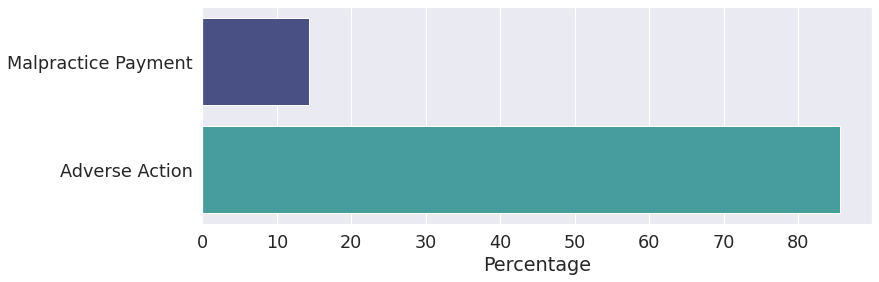

In [ ]:
sns.set(font_scale=1.6)
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.barplot(x = 'Percentage', y = 'Report Type', data = vis_df_1, palette="mako")
ax.set_ylabel('')

Out of \~1.5 million rows of reports, 14.38% (\~223,000) results in a malpractice payment, whereas the remaining 85.62% (\~1.3 million) does not result in a payment. 

**PAYMENT GROUP**

In [ ]:
#Check the distribution of payment
%%spark

query = '''
SELECT int(TOTALPMT_FLOAT), COUNT(*) AS count
FROM sdf_3
WHERE TOTALPMT_FLOAT IS NOT NULL
GROUP BY TOTALPMT_FLOAT
ORDER BY TOTALPMT_FLOAT ASC
'''

eda_sdf_3 = spark.sql(query)
eda_sdf_3.show()
eda_sdf_3.createOrReplaceTempView('eda_sdf_3')

query = '''
SELECT COUNT(TOTALPMT_FLOAT) AS number_of_totalpmt_groups
FROM eda_sdf_3
'''

eda_sdf_4 = spark.sql(query)
eda_sdf_4.show()

query = '''
SELECT SUM(count) AS check_count
FROM eda_sdf_3
'''

check_4 = spark.sql(query)
check_4.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Currently there are 215 payment groups. Would need to group this to visualize things a bit better.

In [ ]:
# Payment group using payment data without inflation adjustment
%%spark

query = '''
WITH a AS (SELECT TOTALPMT_GROUP AS PMTGROUP, COUNT(*) AS count 
FROM sdf_4
WHERE TOTALPMT IS NOT NULL
GROUP BY TOTALPMT_GROUP),

b AS (SELECT COUNT(*) AS count
FROM sdf_4
WHERE TOTALPMT IS NOT NULL)

SELECT a.PMTGROUP, a.count, (a.count/b.count) AS PCT_PMT
FROM a, b
ORDER BY PMTGROUP
'''

eda_sdf_5 = spark.sql(query)
eda_sdf_5.show()
eda_sdf_5.createOrReplaceTempView('eda_sdf_5')

In [ ]:
vis_df_2 = pd.read_csv('/content/drive/MyDrive/Practicum/visualization_csvs/pmt_group.csv')
vis_df_2 = vis_df_2.reindex([0,3,1,2,4]).reset_index(drop= True)
vis_df_2['PCT_PMT'] = vis_df_2['PCT_PMT'] * 100
vis_df_2 = vis_df_2.rename(columns={"PMTGROUP": "Payment Group", "count": "Count", "PCT_PMT": "Percentage"})

# reverse the order of rows
vis_df_2 = vis_df_2.reindex(index=vis_df_2.index[::-1])

vis_df_2

In [ ]:
vis_df_2['Count'].sum()

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x = 'Percentage', y = 'Payment Group', data = vis_df_2, palette='mako')

In [ ]:
#%%spark
#eda_sdf_5.coalesce(1).write.format('csv').option('header','true').save('s3://dspracticum/visualization_csvs/pmt_group')

In [ ]:
# Payment group using inflation adjusted data
%%spark

query = '''
WITH a AS (SELECT TOTALPMT_ADJ_GROUP AS PMTGROUP, COUNT(*) AS count 
FROM sdf_4
WHERE TOTALPMT IS NOT NULL
GROUP BY TOTALPMT_ADJ_GROUP),

b AS (SELECT COUNT(*) AS count
FROM sdf_4
WHERE TOTALPMT IS NOT NULL)

SELECT a.PMTGROUP, a.count, (a.count/b.count) AS PCT_PMT
FROM a, b
ORDER BY PMTGROUP
'''

eda_sdf_6 = spark.sql(query)
eda_sdf_6.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------+--------------------+
|            PMTGROUP| count|             PCT_PMT|
+--------------------+------+--------------------+
|          0 - 99,999| 81700| 0.36485267454426906|
|1,000,000 - 9,999...| 21388|  0.0955136964890187|
|10,000,000 - 99,9...|   127|5.671516483123889E-4|
|   100,000 - 999,999|120710|  0.5390620115573895|
|100,000,000 - 999...|     1|4.465761010333771E-6|
+--------------------+------+--------------------+

In [ ]:
vis_df_3 = pd.read_csv('/content/drive/MyDrive/Practicum/visualization_csvs/pmt_group_adj.csv')
vis_df_3 = vis_df_3.reindex([0,3,1,2,4]).reset_index(drop= True)
vis_df_3['PCT_PMT'] = vis_df_3['PCT_PMT'] * 100
vis_df_3 = vis_df_3.rename(columns={"PMTGROUP": "Payment Group", "PCT_PMT": "Percentage"})

# reverse the order of rows
vis_df_3 = vis_df_3.reindex(index=vis_df_3.index[::-1])

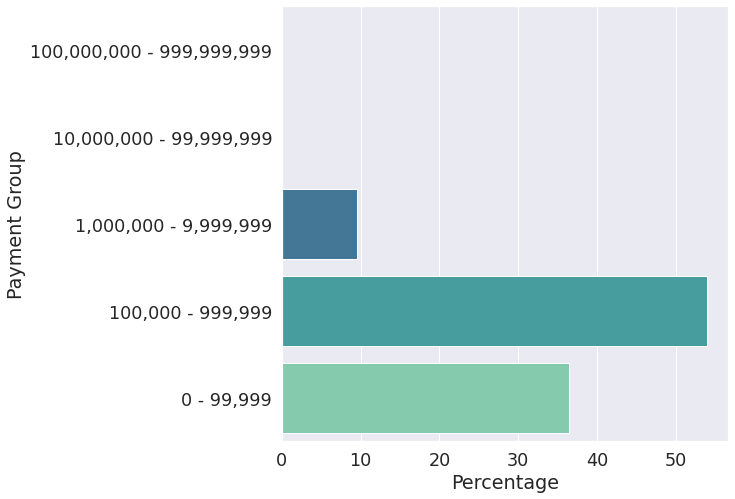

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.barplot(x = 'Percentage', y = 'Payment Group', data = vis_df_3, palette="mako")

Adjusting the historical total payments to APR 2021 levels have more than doubled the percentage of payment in 1,000,000+ group

In [ ]:
#%%spark
#eda_sdf_6.coalesce(1).write.format('csv').option('header','true').save('s3://dspracticum/visualization_csvs/pmt_group_adj')

In [ ]:
%%spark

query = '''
SELECT *, groupPayment(TOTALPMT_FLOAT) AS PMTGROUP
FROM eda_sdf_3
'''
eda_sdf_16 = spark.sql(query)
eda_sdf_16.show(10)
eda_sdf_16

In [ ]:
# converting from spark to pandas to create seaborn plots
%%spark

totalpmt_distribution = eda_sdf_3.toPandas()
totalpmt_distribution

**LICNSTAT & WORKSTAT**

In [ ]:
# To see how many reports come from each state (according to LICNSTAT and WORKSTAT variables)
%%spark

query = '''
WITH a AS (SELECT WORKSTAT, COUNT(*) AS Count
FROM sdf_3
GROUP BY WORKSTAT
ORDER BY WORKSTAT ASC),

b AS (SELECT LICNSTAT, COUNT(*) AS Count
FROM sdf_3
GROUP BY LICNSTAT
ORDER BY LICNSTAT ASC)

SELECT WORKSTAT, a.Count AS WORKSTAT_COUNT, LICNSTAT, b.Count AS LICNSTAT_COUNT
FROM a JOIN b ON a.WORKSTAT = b.LICNSTAT
ORDER BY a.WORKSTAT ASC
'''

eda_sdf_7 = spark.sql(query)
eda_sdf_7.show(60)


In [ ]:
# To see how many reports come from each state (according to LICNSTAT and WORKSTAT variables)
# Where TOTALPMT IS NOT NULL
%%spark

query = '''
WITH a AS (SELECT WORKSTAT, COUNT(*) AS Count
FROM sdf_3
WHERE TOTALPMT IS NOT NULL
GROUP BY WORKSTAT
ORDER BY WORKSTAT ASC),

b AS (SELECT LICNSTAT, COUNT(*) AS Count
FROM sdf_3
WHERE TOTALPMT IS NOT NULL
GROUP BY LICNSTAT
ORDER BY LICNSTAT ASC)

SELECT WORKSTAT, a.Count AS WORKSTAT_COUNT, LICNSTAT, b.Count AS LICNSTAT_COUNT
FROM a JOIN b ON a.WORKSTAT = b.LICNSTAT
ORDER BY a.WORKSTAT ASC
'''

eda_sdf_8 = spark.sql(query)
eda_sdf_8.show(60)

In [ ]:
#processing WORKSTAT as it's own
#%%spark
#eda_sdf_7.coalesce(1).write.format('csv').option('header','true').save('s3://dspracticum/sdf/state_distribution')
#eda_sdf_8.coalesce(1).write.format('csv').option('header','true').save('s3://dspracticum/sdf/state_distribution_payment_only')

In [ ]:
vis_df_4 = pd.read_csv('/content/drive/MyDrive/Practicum/dataframe/state_distribution.csv')
vis_df_5 = pd.read_csv('/content/drive/MyDrive/Practicum/dataframe/state_distribution_payment_only.csv')

In [ ]:
vis_df_4_workstat = vis_df_4[['WORKSTAT', 'WORKSTAT_COUNT']]
vis_df_4_workstat = vis_df_4_workstat.sort_values(by = ['WORKSTAT_COUNT'], ascending = False)
vis_df_4_workstat['PERCENTAGE'] = vis_df_4_workstat['WORKSTAT_COUNT'].apply(lambda x: x/vis_df_4_workstat['WORKSTAT_COUNT'].sum() * 100)
vis_df_4_workstat

In [ ]:
vis_df_4_licnstat = vis_df_4[['LICNSTAT', 'LICNSTAT_COUNT']]
vis_df_4_licnstat = vis_df_4_licnstat.sort_values(by = ['LICNSTAT_COUNT'], ascending = False)
vis_df_4_licnstat['PERCENTAGE'] = vis_df_4_licnstat['LICNSTAT_COUNT'].apply(lambda x: x/vis_df_4_licnstat['LICNSTAT_COUNT'].sum() * 100)
vis_df_4_licnstat

These are the count of reports which results in some payment

In [ ]:
vis_df_5_workstat = vis_df_5[['WORKSTAT', 'WORKSTAT_COUNT']]
vis_df_5_workstat = vis_df_5_workstat.sort_values(by = ['WORKSTAT_COUNT'], ascending = False)
vis_df_5_workstat['PERCENTAGE'] = vis_df_5_workstat['WORKSTAT_COUNT'].apply(lambda x: x/vis_df_5_workstat['WORKSTAT_COUNT'].sum() * 100)
vis_df_5_workstat

In [ ]:
vis_df_5_licnstat = vis_df_5[['LICNSTAT', 'LICNSTAT_COUNT']]
vis_df_5_licnstat = vis_df_5_licnstat.sort_values(by = ['LICNSTAT_COUNT'], ascending = False)
vis_df_5_licnstat['PERCENTAGE'] = vis_df_5_licnstat['LICNSTAT_COUNT'].apply(lambda x: x/vis_df_5_licnstat['LICNSTAT_COUNT'].sum() * 100)
vis_df_5_licnstat

**AGE**

In [ ]:
# Age distribution

%%spark

query = '''
WITH a AS (SELECT PRACTAGE, COUNT(*) AS count
FROM sdf_3
GROUP BY PRACTAGE),

b AS (SELECT PRACTAGE, COUNT(*) AS count
FROM sdf_3
WHERE TOTALPMT IS NOT NULL
GROUP BY PRACTAGE)

SELECT a.PRACTAGE, a.count AS count_all, b.count AS count_totalpmt_not_null, (b.count / a.count) AS PCT_PMT
FROM a JOIN b ON a.PRACTAGE = b.PRACTAGE
ORDER BY a.PRACTAGE ASC
'''

eda_sdf_9 = spark.sql(query)
eda_sdf_9.show(20)

In [ ]:
%%spark

query = '''
SELECT PRACTAGE, count(*) AS Count
FROM sdf_7
GROUP BY PRACTAGE
ORDER BY PRACTAGE ASC
'''

eda_sdf_10 = spark.sql(query)
eda_sdf_10.show()

In [ ]:
%%spark

query = '''
SELECT PRACTAGE, count(*) AS Count
FROM sdf_7
WHERE TOTALPMT IS NOT NULL
GROUP BY PRACTAGE
ORDER BY PRACTAGE ASC
'''

eda_sdf_11 = spark.sql(query)
eda_sdf_11.show()

In [ ]:
%%spark
eda_sdf_10.coalesce(1).write.format('csv').option('header','true').save('s3://dspracticum/sdf/age_distribution')
eda_sdf_11.coalesce(1).write.format('csv').option('header','true').save('s3://dspracticum/sdf/age_distribution_payment_only')

In [ ]:
vis_df_6 = pd.read_csv('/content/drive/MyDrive/Practicum/visualization_csvs/age_distribution.csv')
vis_df_6['Percentage'] = vis_df_6['Count'].apply(lambda x: x/vis_df_6['Count'].sum() * 100)
vis_df_6['Practitioner Age Group'] = vis_df_6['PRACTAGE'].apply(lambda x: str(x)[:2])

vis_df_6

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.barplot(x = 'Practitioner Age Group', y = 'Percentage', data = vis_df_6, palette="mako")

In [ ]:
vis_df_7 = pd.read_csv('/content/drive/MyDrive/Practicum/visualization_csvs/age_distribution_payment_only.csv')
vis_df_7['Percentage'] = vis_df_7['Count'].apply(lambda x: x/vis_df_7['Count'].sum() * 100)
vis_df_7['Practitioner Age Group'] = vis_df_7['PRACTAGE'].apply(lambda x: str(x)[:2])

vis_df_7

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.barplot(x = 'Practitioner Age Group', y = 'Percentage', data = vis_df_7, palette="mako")


**GRADUATION**

In [ ]:
# GRAD year distribution

#%%spark

#query = '''
#WITH a AS (SELECT GRAD, COUNT(*) AS count
#FROM sdf_3
#GROUP BY GRAD
#ORDER BY GRAD ASC),

#b AS (SELECT GRAD, COUNT(*) AS count
#FROM sdf_3
#WHERE TOTALPMT IS NOT NULL
#GROUP BY GRAD
#order by GRAD ASC)

#SELECT *, (b.count / a.count) AS PCT_PMT
#FROM a JOIN b ON a.GRAD = b.GRAD
#ORDER BY a.GRAD ASC
#'''

#eda_sdf_6 = spark.sql(query)
#eda_sdf_6.show(20)

**EXPERIENCE**

In [ ]:
# Distribution of payment wh

%%spark

query = '''
WITH a AS (SELECT PRACTEXP_ADJ, COUNT(*) AS count
FROM sdf_7
GROUP BY PRACTEXP_ADJ),

b AS (SELECT PRACTEXP_ADJ, COUNT(*) AS count
FROM sdf_7
WHERE TOTALPMT IS NOT NULL
GROUP BY PRACTEXP_ADJ)

SELECT *, (b.count / a.count) AS PCT_PMT
FROM a JOIN b ON a.PRACTEXP_ADJ = b.PRACTEXP_ADJ
ORDER BY a.PRACTEXP_ADJ ASC
'''

eda_sdf_15 = spark.sql(query)
eda_sdf_15.show(100)

In [ ]:
%%spark

query = '''
SELECT PRACTEXP_ADJ, COUNT(*) AS count
FROM sdf_7
GROUP BY PRACTEXP_ADJ
ORDER BY PRACTEXP_ADJ ASC
'''

eda_sdf_16 = spark.sql(query)
eda_sdf_16.show()

In [ ]:
%%spark

query = '''
SELECT PRACTEXP_ADJ, COUNT(*) AS count
FROM sdf_7
WHERE TOTALPMT IS NOT NULL
GROUP BY PRACTEXP_ADJ
ORDER BY PRACTEXP_ADJ ASC
'''

eda_sdf_17 = spark.sql(query)
eda_sdf_17.show()

In [ ]:
%%spark

query = '''
SELECT PRACTEXP_GROUP, COUNT(*) AS count
FROM sdf_7
GROUP BY PRACTEXP_GROUP
ORDER BY PRACTEXP_GROUP ASC
'''

eda_sdf_18 = spark.sql(query)
eda_sdf_18.show()

In [ ]:
%%spark

query = '''
SELECT PRACTEXP_GROUP, COUNT(*) AS count
FROM sdf_7
WHERE TOTALPMT IS NOT NULL
GROUP BY PRACTEXP_GROUP
ORDER BY PRACTEXP_GROUP ASC
'''

eda_sdf_19 = spark.sql(query)
eda_sdf_19.show()

In [ ]:
%%spark
eda_sdf_16.coalesce(1).write.format('csv').option('header','true').save('s3://dspracticum/sdf/practexp_adj_distribution')
eda_sdf_17.coalesce(1).write.format('csv').option('header','true').save('s3://dspracticum/sdf/practexp_adj_distribution_payment_only')
eda_sdf_18.coalesce(1).write.format('csv').option('header','true').save('s3://dspracticum/sdf/practexp_group_distribution')
eda_sdf_19.coalesce(1).write.format('csv').option('header','true').save('s3://dspracticum/sdf/practexp_group_distribution_payment_only')

In [ ]:
def label(x):
  label = str(x)
  if label == 'nan':
    label = 'na'
  else:
    if len(label) == 3:
      label = label[:1]
    else:
      label = label[:2]

  return label

In [ ]:
vis_df_8 = pd.read_csv('/content/drive/MyDrive/Practicum/visualization_csvs/practexp_adj_distribution.csv')
vis_df_8['Percentage'] = vis_df_8['count'].apply(lambda x: x/vis_df_8['count'].sum() * 100)
vis_df_8['Practitioner Experience Years'] = vis_df_8['PRACTEXP_ADJ'].apply(lambda x: label(x))
vis_df_8

In [ ]:
vis_df_9 = pd.read_csv('/content/drive/MyDrive/Practicum/visualization_csvs/practexp_adj_distribution_payment_only.csv')
vis_df_9['Percentage'] = vis_df_9['count'].apply(lambda x: x/vis_df_9['count'].sum() * 100)
vis_df_9['Practitioner Experience Years'] = vis_df_9['PRACTEXP_ADJ'].apply(lambda x: label(x))
vis_df_9

In [ ]:
vis_df_10 = pd.read_csv('/content/drive/MyDrive/Practicum/visualization_csvs/practexp_group_distribution.csv')
vis_df_10['Percentage'] = vis_df_10['count'].apply(lambda x: x/vis_df_10['count'].sum() * 100)
vis_df_10['Practitioner Experience Group'] = vis_df_10['PRACTEXP_GROUP'].apply(lambda x: label(x))
vis_df_10

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(x = 'Practitioner Experience Group', y = 'count', data = vis_df_10, palette="mako")

In [ ]:
vis_df_11 = pd.read_csv('/content/drive/MyDrive/Practicum/visualization_csvs/practexp_group_distribution_payment_only.csv')
vis_df_11['Percentage'] = vis_df_11['count'].apply(lambda x: x/vis_df_11['count'].sum() * 100)
vis_df_11['Practitioner Experience Group'] = vis_df_11['PRACTEXP_GROUP'].apply(lambda x: label(x))
vis_df_11

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(x = 'Practitioner Experience Group', y = 'Percentage', data = vis_df_11, palette="mako")

**ALGNNATR**

Allegation Attribute (ALGNNATR) Value Label


*   1 Diagnosis Related
*   10 Anesthesia Related
*   20 Surgery Related
*   30 Medication Related
*   40 IV & Blood Products Related
*   50 Obstetrics Related
*   60 Treatment Related
*   70 Monitoring Related
*   80 Equipment/Product Related
*   90 Other Miscellaneous
*   100 Behavioral Health Related



















In [ ]:
#Allegation Attribute

%%spark

query = '''
SELECT ALGNNATR, COUNT(*) AS count
FROM sdf_3
GROUP BY ALGNNATR
ORDER BY ALGNNATR ASC
'''

eda_sdf_8 = spark.sql(query)
eda_sdf_8.show(20)

In [ ]:
# Move the ALEGATN1 labels from csv to Spark DF
%%spark
label_sdf = spark_reader.csv('s3://dspracticum/ALEGATN1.csv',inferSchema = True, header = True)
label_sdf.show(10)
label_sdf.createOrReplaceTempView('alegatn1_sdf')

In [ ]:
%%spark

query = '''
SELECT ALEGATN1, count(*) as count
FROM sdf_7
GROUP BY ALEGATN1
'''

eda_sdf_20 = spark.sql(query)
eda_sdf_20.show()

In [ ]:
%%spark

query = '''
SELECT *
FROM sdf_7 a LEFT JOIN alegatn1_sdf b ON a.ALEGATN1 = b.Value 
'''

eda_sdf_20 = spark.sql(query)
eda_sdf_20.show()

In [ ]:
%%spark
eda_sdf_20.count()

In [ ]:
#Allegation Attribute

%%spark

query = '''
WITH a AS (SELECT ALEGATN1, COUNT(*) AS count
FROM sdf_3 
GROUP BY ALEGATN1)

SELECT ALEGATN1, Label, count
FROM a LEFT JOIN alegatn1_sdf b ON a.ALEGATN1 = b.Value
ORDER BY COUNT DESC
'''

eda_sdf_21 = spark.sql(query)
eda_sdf_21.show(100)
eda_sdf_21.createOrReplaceTempView('eda_sdf_21')

In [ ]:
%%spark

query = '''
SELECT SUM(count)
FROM eda_sdf_21
'''

check_sdf = spark.sql(query)
check_sdf.show()

In [ ]:
# Count of ALEGATN1 which results in payment 
# To add later: min, max, and average payment

#Allegation Attribute

%%spark

query = '''
WITH a AS (SELECT ALEGATN1, COUNT(*) AS count
FROM sdf_3
WHERE TOTALPMT IS NOT NULL 
GROUP BY ALEGATN1)

SELECT ALEGATN1, Label, count
FROM a LEFT JOIN alegatn1_sdf b ON a.ALEGATN1 = b.Value
ORDER BY COUNT DESC
'''

eda_sdf_22 = spark.sql(query)
eda_sdf_22.show(100)
eda_sdf_22.createOrReplaceTempView('eda_sdf_22')

In [ ]:
%%spark
eda_sdf_21.coalesce(1).write.format('csv').option('header','true').save('s3://dspracticum/sdf/alegatn1_distribution')
eda_sdf_22.coalesce(1).write.format('csv').option('header','true').save('s3://dspracticum/sdf/alegatn1_distribution_payment_only')

In [ ]:
vis_df_12 = pd.read_csv('/content/drive/MyDrive/Practicum/visualization_csvs/alegatn1_distribution.csv')
vis_df_12['Percentage'] = vis_df_12['count'].apply(lambda x: x/vis_df_12['count'].sum() * 100)
#vis_df_11['Practitioner Experience Group'] = vis_df_11['PRACTEXP_GROUP'].apply(lambda x: label(x))
vis_df_12

In [ ]:
vis_df_12['count'].sum() 

In [ ]:
vis_df_12_top20 = vis_df_12[:20]
vis_df_12_top20['Allegation'] = vis_df_12_top20['Label'].copy()
vis_df_12_top20

Distribution by allegation:

1.   Allegation (ALEGATN1) unlabeled: 1,083,272
2.   Allegation (ALEGATN1) labeled: 474,429

Below represents the distribution labeled records (474,429 rows total). Percentage is out of the entire 1,557,701 rows. 

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(x = 'Percentage', y = 'Allegation', data = vis_df_12_top20, palette="mako")

In [ ]:
vis_df_13 = pd.read_csv('/content/drive/MyDrive/Practicum/visualization_csvs/alegatn1_distribution_payment_only.csv')
vis_df_13['Percentage'] = vis_df_13['count'].apply(lambda x: x/vis_df_13['count'].sum() * 100)

vis_df_13

In [ ]:
vis_df_13['count'].sum()

In [ ]:
vis_df_13_top20 = vis_df_13[:20]
vis_df_13_top20['Allegation'] = vis_df_13_top20['Label'].copy()
vis_df_13_top20

This is the distribution of records by allegation *where total payment is not null.* Percentage is out of 223,926, the number of rows where allegation results in some payment.

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(x = 'Percentage', y = 'Allegation', data = vis_df_13_top20, palette="mako")

**LICNFELD**

In [ ]:
# Move the license field labels from csv to Spark DF
%%spark
licnfeld_sdf = spark_reader.csv('s3://dspracticum/LICNFELD.csv',inferSchema = True, header = True)
licnfeld_sdf.show(10)
licnfeld_sdf.createOrReplaceTempView('licnfeld_sdf')

In [ ]:
%%spark

query = '''
SELECT *
FROM sdf_7 a LEFT JOIN licnfeld_sdf b ON a.LICNFELD = b.Value
'''

eda_sdf_23 = spark.sql(query)
eda_sdf_23.show(10)
eda_sdf_23.createOrReplaceTempView('eda_sdf_23')

In [ ]:
%%spark

query = '''
SELECT LICNFELD, count(*) AS count
FROM eda_sdf_23
GROUP BY LICNFELD
ORDER BY count DESC
'''

eda_sdf_24 = spark.sql(query)
eda_sdf_24.show(10)
eda_sdf_24.createOrReplaceTempView('eda_sdf_24')

In [ ]:
%%spark

query = '''
SELECT LICNFELD, count, Label
FROM eda_sdf_24 a LEFT JOIN licnfeld_sdf b ON a.LICNFELD = b.Value
ORDER BY count DESC
'''

eda_sdf_25 = spark.sql(query)
eda_sdf_25.show(10)
eda_sdf_25.createOrReplaceTempView('eda_sdf_25')

In [ ]:
%%spark

query = '''
SELECT SUM(count)
FROM eda_sdf_25
'''

check = spark.sql(query)
check.show()

In [ ]:
%%spark

query = '''
SELECT LICNFELD, count(*) AS count
FROM eda_sdf_23
WHERE TOTALPMT IS NOT NULL
GROUP BY LICNFELD
ORDER BY count DESC
'''

eda_sdf_26 = spark.sql(query)
eda_sdf_26.show(10)
eda_sdf_26.createOrReplaceTempView('eda_sdf_26')

In [ ]:
%%spark

query = '''
SELECT SUM(count)
FROM eda_sdf_26
'''

check = spark.sql(query)
check.show()

In [ ]:
%%spark

query = '''
SELECT LICNFELD, count, Label
FROM eda_sdf_26 a LEFT JOIN licnfeld_sdf b ON a.LICNFELD = b.Value
ORDER BY count DESC
'''

eda_sdf_27 = spark.sql(query)
eda_sdf_27.show(10)

In [ ]:
%%spark
eda_sdf_25.coalesce(1).write.format('csv').option('header','true').save('s3://dspracticum/sdf/licnfeld_distribution')
eda_sdf_27.coalesce(1).write.format('csv').option('header','true').save('s3://dspracticum/sdf/licnfeld_distribution_payment_only')

In [ ]:
vis_df_14 = pd.read_csv('/content/drive/MyDrive/Practicum/visualization_csvs/licnfeld_distribution.csv')

In [ ]:
vis_df_14['Percentage'] = vis_df_14['count'].apply(lambda x: x/vis_df_14['count'].sum() * 100)
vis_df_14['License Field'] = vis_df_14['Label'].copy()
vis_df_14_top20 = vis_df_14[:20]
vis_df_14_top20

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(x = 'Percentage', y = 'License Field', data = vis_df_14_top20, palette="mako")

In [ ]:
vis_df_15 = pd.read_csv('/content/drive/MyDrive/Practicum/visualization_csvs/licnfeld_distribution_payment_only.csv')

In [ ]:
vis_df_15['Percentage'] = vis_df_15['count'].apply(lambda x: x/vis_df_15['count'].sum() * 100)
vis_df_15['License Field'] = vis_df_15['Label'].copy()
vis_df_15_top20 = vis_df_15[:20]
vis_df_15_top20

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(x = 'Percentage', y = 'License Field', data = vis_df_15_top20, palette="mako")

In [ ]:
%%spark

query = '''
SELECT LICNFELD, report_count, Label AS license_field
FROM eda_sdf_23 a JOIN licnfeld_sdf b ON a.LICNFELD = b.Value
WHERE TOTALPMT IS NOT NULL
ORDER BY report_count DESC
'''

eda_sdf_25 = spark.sql(query)
eda_sdf_25.show(10)

In [ ]:
# write a .csv of the above
%%spark

eda_sdf_12.coalesce(1).write.format('csv').option('header','true').save('s3://dspracticum/sdf/licnfeld_count')

In [ ]:
# Number of reports by License Field (LICNFELD) which results in payment 

%%spark

query = '''
SELECT LICNFELD, COUNT(*) AS payment_count, INT(MIN(TOTALPMT_ADJ)) AS MIN_PMT, INT(MAX(TOTALPMT_ADJ)) AS MAX_PMT, INT(AVG(TOTALPMT_ADJ)) AS AVG_PMT
FROM sdf_3
WHERE TOTALPMT IS NOT NULL
GROUP BY LICNFELD
ORDER BY payment_count DESC
'''

eda_sdf_12 = spark.sql(query)
eda_sdf_12.show(100)
eda_sdf_12.createOrReplaceTempView('eda_sdf_12')

In [ ]:
# Calculates the percentage of report that results in payment for each License Field (LICNFELD)
%%spark

query = '''
SELECT a.LICNFELD AS LICNFELD,
  Label,
  report_count, 
  payment_count, 
  (b.payment_count / a.report_count) AS PCT_PMT,
  MIN_PMT,
  MAX_PMT,
  AVG_PMT
FROM eda_sdf_11 a 
  JOIN eda_sdf_12 b ON a.LICNFELD = b.LICNFELD
  JOIN licnfeld_sdf c ON a.LICNFELD = c.Value
ORDER BY AVG_PMT desc
'''

eda_sdf_13 = spark.sql(query)
eda_sdf_13.show(100)

In [ ]:
#%%spark
#eda_sdf_13.coalesce(1).write.format('csv').option('header','true').save('s3://dspracticum/visualization_csvs/eda_sdf_13')

In [ ]:
vis_df = pd.read_csv('/content/drive/MyDrive/Practicum/visualization_csvs/eda_sdf_13.csv')
vis_df

In [ ]:
vis_df = vis_df[:20]

In [ ]:
sns.histplot(vis_df, x = 'Label', y = 'payment_count')

In [ ]:
# Move the license field labels from csv to Spark DF
%%spark
outcome_sdf = spark_reader.csv('s3://dspracticum/OUTCOME.csv',inferSchema = True, header = True)
outcome_sdf.show(10)
outcome_sdf.createOrReplaceTempView('outcome_sdf')

In [ ]:
%%spark
query = '''
SELECT OUTCOME, COUNT(*) AS count,  MIN(TOTALPMT_ADJ) AS MIN_PMT, MAX(TOTALPMT_ADJ) AS MAX_PMT, AVG(TOTALPMT_ADJ) AS AVG_PMT
FROM sdf_3
GROUP BY OUTCOME'''

eda_sdf_14 = spark.sql(query)
eda_sdf_14.show(11)

In [ ]:
%%spark

query = '''
WITH a AS (SELECT OUTCOME, COUNT(*) AS count
FROM sdf_3
GROUP BY OUTCOME),

b AS (SELECT OUTCOME, COUNT(*) AS count
FROM sdf_3
WHERE TOTALPMT IS NOT NULL
GROUP BY OUTCOME),

c AS (SELECT OUTCOME,  INT(MIN(TOTALPMT_ADJ)) AS MIN_PMT, INT(MAX(TOTALPMT_ADJ)) AS MAX_PMT, INT(AVG(TOTALPMT_ADJ)) AS AVG_PMT
FROM sdf_3
GROUP BY OUTCOME)

SELECT *, (b.count / a.count) AS PCT_PMT
FROM a 
  JOIN b ON a.OUTCOME = b.OUTCOME
  JOIN c ON a.OUTCOME = c.OUTCOME
  JOIN outcome_sdf d ON a.OUTCOME = d.Value
ORDER BY a.OUTCOME ASC
'''

eda_sdf_14 = spark.sql(query)
eda_sdf_14.show(11)

The above analysis on the variable outcome indicates that within the data, all reports whose outcomes are known result in some payment. This is likely because a judgment/settlement is needed to determine the outcome (The judgment/settlement is needed because plaintiff/defendant may have different assessment on the outcome, whether the outcome actually occurs or was caused by the defendant). 

This variable can be used if the user is certain that a malpractice occured and the outcome is known (such as when a doctor admits that he made an erroneous action that resulted in the outcome). It should not be used otherwise (such as when the outcome is known but the cause is disputed).

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Practicum/dataframe/main_sdf_pmt.csv')
licnfeld_df = df[['SEQNO', 'LICNFELD', 'TOTALPMT_FLOAT', 'TOTALPMT_ADJ', 'TOTALPMT_GROUP', 'TOTALPMT_ADJ_GROUP']]

licnfeld_df
            

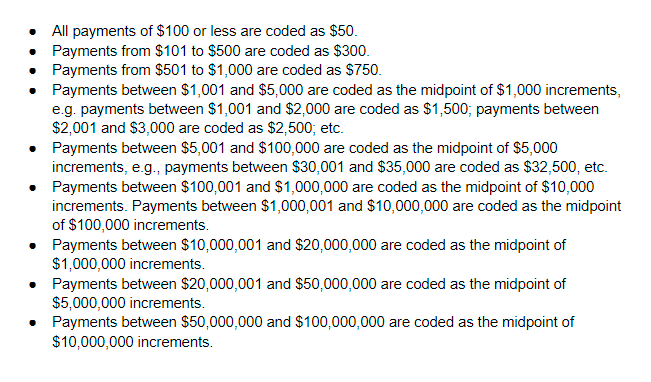



II.a Payment Data Analysis

From NPDB Public Use Data File description pdf.

Out of ~1.5 million rows of data we have 223,926 rows which have information medical malpractice payment

**Inflationary Adjustment to PAYMENT and TOTALPMT attributes**

We use CPI information from the Bureau of Labor and Statistics Website to adjust for inflation.
https://www.bls.gov/cpi/home.htm

Notes: need to see if type of adverse action is known at the time claim is made.